<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/DQN(Simple).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



[Episode 0] Starting with epsilon = 1.00
 Step  0 | State: [0 0 0 0] | Action: 0 | Reward: -1 | Done: False
 Step  1 | State: [-0.09 -0.01 -0.16 -0.01] | Action: 0 | Reward: -1 | Done: True

[Episode 1] Starting with epsilon = 1.00
 Step  0 | State: [0 0 0 0] | Action: 1 | Reward: +1 | Done: False
 Step  1 | State: [ 0.04 -0.07  0.04 -0.05] | Action: 3 | Reward: -1 | Done: False
 Step  2 | State: [ 0.05 -0.32  0.32 -0.24] | Action: 1 | Reward: +1 | Done: False
 Step  3 | State: [ 0.11 -0.18  0.37 -0.27] | Action: 1 | Reward: +1 | Done: False
 Step  4 | State: [ 0.31 -0.24  0.27 -0.36] | Action: 0 | Reward: -1 | Done: False
 Step  5 | State: [ 0.21 -0.15  0.26 -0.25] | Action: 2 | Reward: -1 | Done: False
 Step  6 | State: [ 0.32 -0.09  0.4  -0.34] | Action: 2 | Reward: -1 | Done: False
 Step  7 | State: [ 0.5  -0.07  0.21 -0.26] | Action: 0 | Reward: -1 | Done: False
 Step  8 | State: [ 0.58 -0.21  0.24 -0.42] | Action: 3 | Reward: -1 | Done: False
 Step  9 | State: [ 0.81 -0.1   0.34

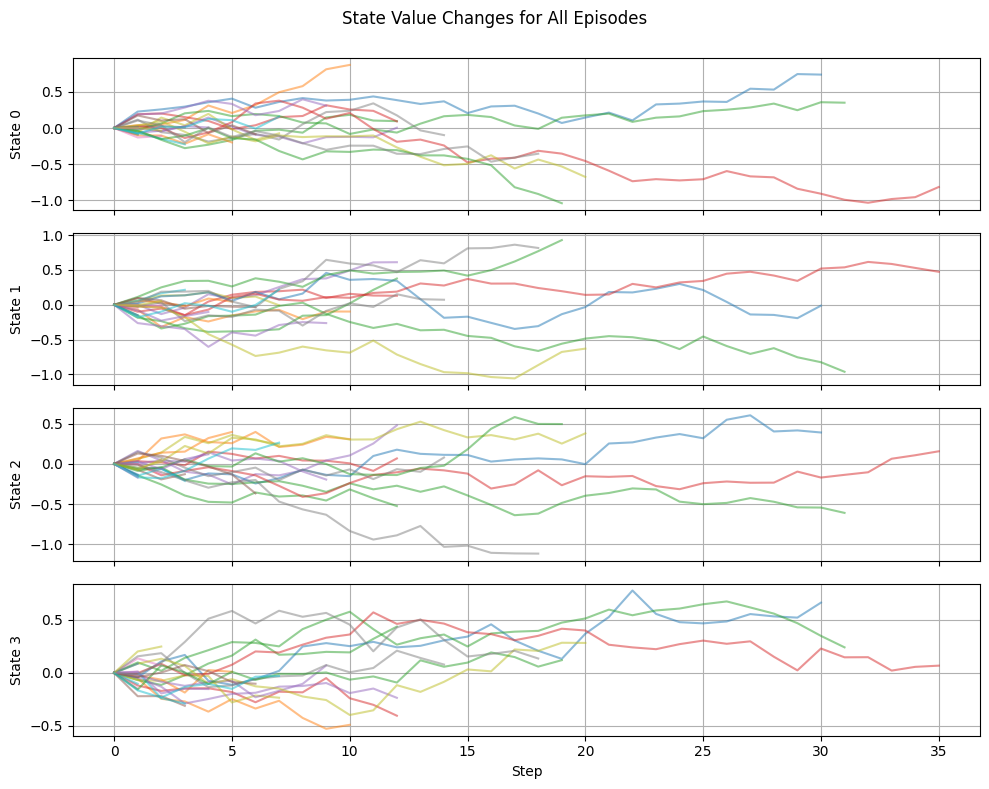

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import random
from collections import deque
import matplotlib.pyplot as plt

# 환경 설정
state_size = 4
action_size = 4

# DQN 파라미터
gamma = 0.95
learning_rate = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 32
memory_size = 2000
train_start = 1000
target_update_freq = 10

memory = deque(maxlen=memory_size)

def build_model():
    model = tf.keras.Sequential([
        layers.Dense(24, input_dim=state_size, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(action_size, activation='linear')
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

model = build_model()
target_model = build_model()

def update_target_network():
    target_model.set_weights(model.get_weights())

def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

"""
np.random.rand()는 [0, 1) 범위의 난수 생성
epsilon은 탐험률 (exploration rate, 예: 1.0 → 완전 랜덤)
조건이 참이면 무작위 행동 선택 → 탐험 (exploration)
-> 학습 초반엔 epsilon = 1.0으로 시작하고, 시간이 지나며 점차 줄이는 방식 (epsilon *= 0.995)을 사용합니다.
"""
def select_action(state):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

def replay():
    global epsilon   # global epsilon은 Python에서 함수 내부에서 전역 변수 epsilon을 수정하고자 할 때 사용하는 키워드입니다.
    if len(memory) < train_start:
        return
    minibatch = random.sample(memory, min(batch_size, len(memory)))

    for state, action, reward, next_state, done in minibatch:
        target = model.predict(state, verbose=0)
        if done:
            target[0][action] = reward # 에피소드 종료 시: target = reward
        else:
            t = target_model.predict(next_state, verbose=0)
            target[0][action] = reward + gamma * np.amax(t[0]) # 비종료 시: target = reward + γ * max_a' Q_target(next_state, a') (감가율 감안)
        model.fit(state, target, epochs=1, verbose=0)

    """
    epsilon	ε-greedy 정책에서의 탐험 확률 (0~1 사이 값)
    epsilon_min	최소 탐험 확률 (예: 0.01 이하로는 줄어들지 않게 제한)
    epsilon_decay	매 스텝 또는 에피소드마다 곱해서 ε를 감소시키는 비율 (예: 0.995)
    """
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# 환경 예시
def get_initial_state():
    return np.reshape([0, 0, 0, 0], [1, state_size]) # Keras의 DNN 모델은 입력을 항상 2차원 배열(batch, features) 형태로 받습니다.

"""
1. noise = np.random.randn(1, state_size) * 0.1
표준 정규분포(평균=0, 표준편차=1)에서 무작위 값 생성 → [1, state_size] 크기의 노이즈
* 0.1: 작은 크기의 변화로 줄임 → 미세한 상태 변화 시뮬레이션

2. next_state = state + noise
현재 상태에 노이즈를 더해 다음 상태 생성
실제 환경에서는 물리적 움직임, 센서 변화 등으로 상태가 바뀌는 것을 흉내냄

3. reward = 1 if action == 1 else -1
action == 1일 때 보상 +1 부여 (예: '올바른 행동'이라는 가정)
그 외 행동에는 -1 부여 → 행동에 따라 보상이 달라지는 간단한 규칙

이 부분은 실제 환경이라면 다음처럼 다양화 가능:
목표에 가까워지면 보상
벽에 부딪히면 벌점 등

4. done = np.random.rand() < 0.1
0~1 사이 난수 중 10% 확률로 에피소드 종료

즉, 평균적으로 10번에 한 번 정도는 종료되는 에피소드
"""
def get_next_state(state, action):
    noise = np.random.randn(1, state_size) * 0.1 # 0.1: 작은 크기의 변화로 줄임 → 미세한 상태 변화 시뮬레이션
    next_state = state + noise
    reward = 1 if action == 1 else -1
    done = np.random.rand() < 0.1
    return next_state, reward, done

# 전체 상태 변화 기록
all_episodes_history = []  # 리스트 안에 [state0[], state1[], state2[], state3[]] 형태

# 학습 루프
episodes = 30

for e in range(episodes):
    state = get_initial_state()
    done = False
    step = 0
    episode_history = [[] for _ in range(state_size)]  # 현재 에피소드의 상태 기록

    print(f"\n[Episode {e}] Starting with epsilon = {epsilon:.2f}")
    while not done:
        action = select_action(state)
        next_state, reward, done = get_next_state(state, action)
        store_experience(state, action, reward, next_state, done)

        s = state[0]
        for i in range(state_size):
            episode_history[i].append(s[i])

        print(f" Step {step:2d} | State: {np.round(s, 2)} | Action: {action} | "
              f"Reward: {reward:+} | Done: {done}")

        state = next_state
        replay()
        step += 1

    all_episodes_history.append(episode_history)

    if e % target_update_freq == 0:
        update_target_network()

print("\n[DQN 학습 완료]")

# 🎯 최종 그래프 출력
fig, axes = plt.subplots(state_size, 1, figsize=(10, 8), sharex=True)
fig.suptitle("State Value Changes for All Episodes")

for i in range(state_size):
    for e, episode_history in enumerate(all_episodes_history):
        axes[i].plot(episode_history[i], label=f"Episode {e}" if i == 0 else "", alpha=0.5)
    axes[i].set_ylabel(f"State {i}")
    axes[i].grid(True)

axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
